In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2

%matplotlib inline

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d((2,2))
        # self.pool2 = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) #28x28x1 => 28x28x32
        x = self.pool(F.relu(x)) #14x14x32
        x = self.dropout(x)
        x = self.conv2(x) #14x14x64
        x = self.pool(F.relu(x)) #7x7x64
        x = self.dropout(x)
        x = x.view(-1, 64*7*7) #flatten
        x = F.relu(self.fc1(x)) #512
        x = self.fc2(x) #128
        # x = F.log_softmax(x, dim=1)
        return x

In [3]:
cnn = Net()
print("CNN: ", cnn)
print()

torch.manual_seed(0)
mini_batch = 1
input = torch.randn(mini_batch, 1, 28, 28, requires_grad=True)
out = cnn(input)
print("output: ", out)
print()
# criterion = nn.CrossEntropyLoss()
print("grads before backward is None:", list(cnn.parameters())[0].grad is None)
print()
cnn.zero_grad()
out.backward(torch.ones(mini_batch,10))

print("grads after backward:")
print(list(cnn.parameters())[0].grad[0])

CNN:  Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

output:  tensor([[-0.5345,  0.2888, -0.1333, -0.2741,  0.7446, -0.4844, -0.0769,  0.0993,
          0.0646, -0.1727]], grad_fn=<AddmmBackward>)

grads before backward is None: True

grads after backward:
tensor([[[-0.0292,  0.0660, -0.0773],
         [ 0.0562,  0.5507, -0.0159],
         [-0.1440,  0.1372, -0.1781]]])


In [4]:
import torchvision
import torchvision.transforms as transforms

batch_size = 100
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../data_mnist', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../data_mnist', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=10000, shuffle=True)

9920512it [00:03, 2500396.95it/s]                                                                                      


Extracting ../data_mnist\MNIST\raw\train-images-idx3-ubyte.gz to ../data_mnist\MNIST\raw


32768it [00:00, 45037.00it/s]                                                                                          


Extracting ../data_mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ../data_mnist\MNIST\raw


1654784it [00:03, 543067.03it/s]                                                                                       


Extracting ../data_mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data_mnist\MNIST\raw


8192it [00:00, 17341.45it/s]                                                                                           


Extracting ../data_mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data_mnist\MNIST\raw
Processing...
Done!


In [5]:
def evaluate():
    test_data, test_labels = list(test_loader)[0]
    outputs = cnn(test_data)
    y_pred = torch.argmax(outputs, 1)
    accuracy = sum(test_labels == y_pred).item()/10000
    return accuracy

In [6]:
# batch_size = 100
# iter_per_epochs = int(train_size/batch_size)
tic = time.time()
toc = time.time()
losses = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters())
# optimizer = optim.SGD(cnn.parameters(), lr=3e-4, momentum=0.9)
for epoch in range(10):
    current_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()    
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        losses.append(loss.item())
        if i%100 == 99:
            print("currently at epochs {}, batch number {}, loss is {}, processing time: {}s".format(epoch+1, i+1, round(current_loss/100, 3), round(time.time()-tic, 2)))
            current_loss = 0
            tic = time.time()
    accuracy = evaluate()
    print("end of epoch {}, accuracy is {}%, processing time: {}s".format(epoch+1, accuracy, round(time.time()-toc, 2)))

currently at epochs 1, batch number 100, loss is 0.655, processing time: 12.8s
currently at epochs 1, batch number 200, loss is 0.23, processing time: 12.39s
currently at epochs 1, batch number 300, loss is 0.183, processing time: 12.56s
currently at epochs 1, batch number 400, loss is 0.159, processing time: 12.43s
currently at epochs 1, batch number 500, loss is 0.132, processing time: 12.64s
currently at epochs 1, batch number 600, loss is 0.114, processing time: 12.99s
end of epoch 0, accuracy is 0.9692%, processing time: 80.4s
currently at epochs 2, batch number 100, loss is 0.102, processing time: 17.32s
currently at epochs 2, batch number 200, loss is 0.098, processing time: 12.4s
currently at epochs 2, batch number 300, loss is 0.099, processing time: 12.1s
currently at epochs 2, batch number 400, loss is 0.083, processing time: 12.2s
currently at epochs 2, batch number 500, loss is 0.08, processing time: 12.09s
currently at epochs 2, batch number 600, loss is 0.084, processing

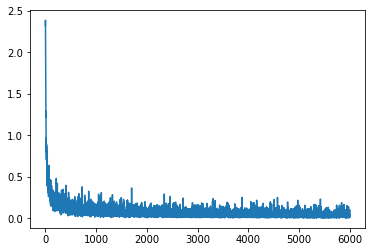

In [7]:
plt.plot(losses)

In [8]:
def predict_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (28, 28))
    plt.imshow(img, cmap="gray")
    plt.show()
    trans_img = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])(img)
    output = cnn(trans_img.view(1,1,28,28))
    pred = torch.argmax(output, 1).item()
    return pred

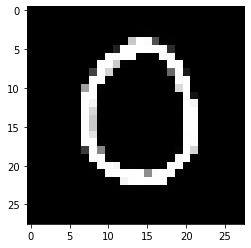

Predicted as 0


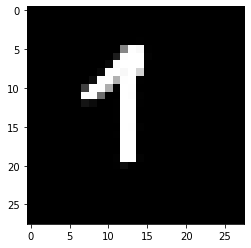

Predicted as 1


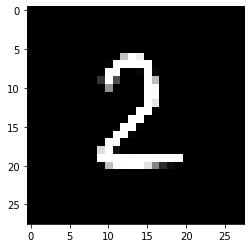

Predicted as 2


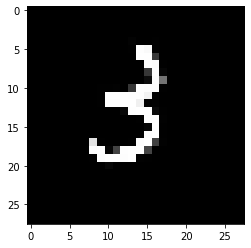

Predicted as 3


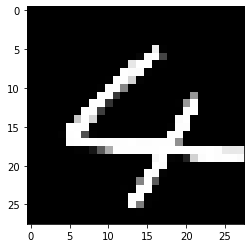

Predicted as 4


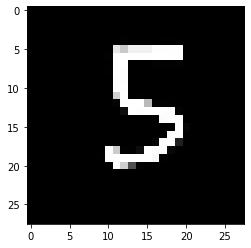

Predicted as 5


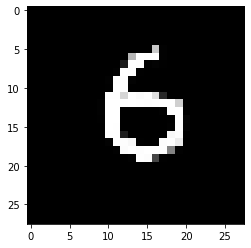

Predicted as 6


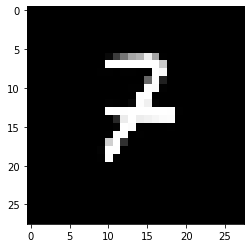

Predicted as 3


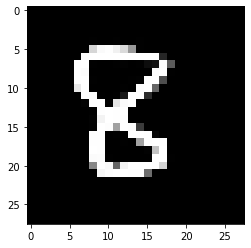

Predicted as 3


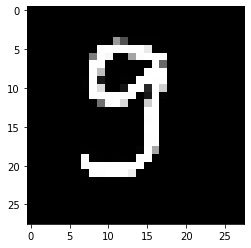

Predicted as 9


In [11]:
for i in range(10):
    path = "test_paint/" + str(i) + ".jpeg"
    prediction = predict_image(path)
    print("Predicted as", prediction)
    print("=================================")

In [21]:
# save the model into disk
torch.save(cnn, "models/CNN_torch/model")

In [24]:
# load the trained model
model = torch.load("models/CNN_torch/model")
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)